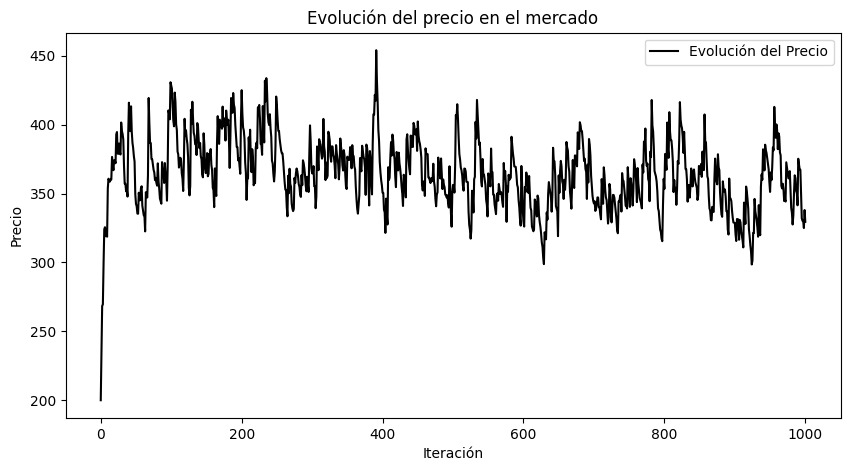

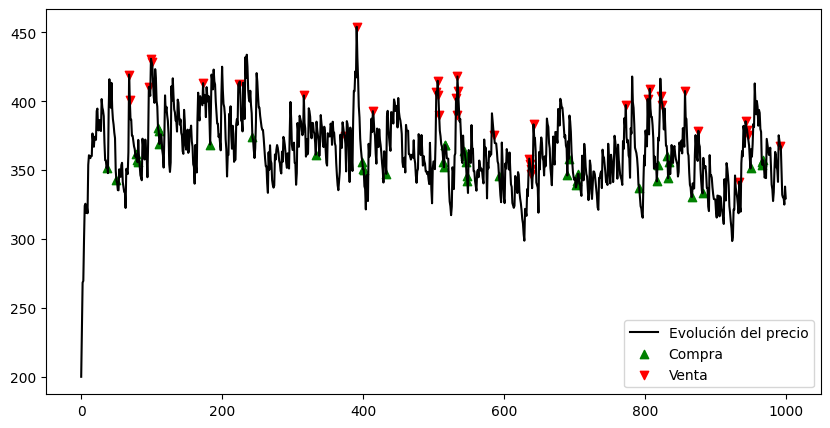

    Tipo de Agente  Balance Promedio
0       tendencial        802.243482
1        aleatorio        957.276305
2  anti-tendencial        210.090143
3           logico       2320.025417


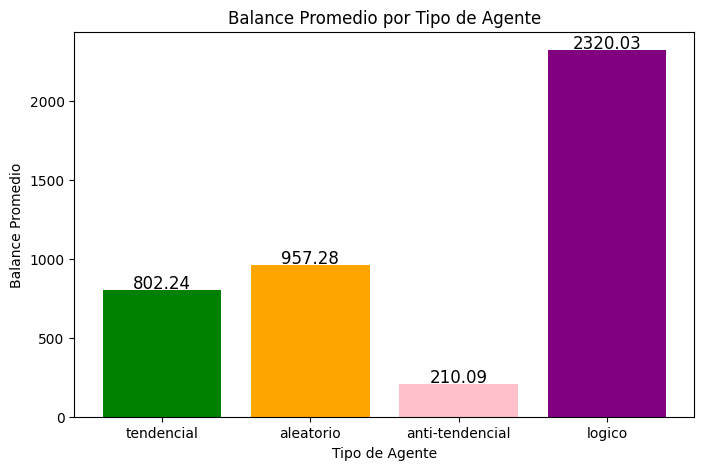

Agente 1: Tipo=tendencial, Balance Final=$1588.53, Tarjetas=0
Agente 2: Tipo=aleatorio, Balance Final=$1195.29, Tarjetas=0
Agente 3: Tipo=aleatorio, Balance Final=$21.74, Tarjetas=4
Agente 4: Tipo=aleatorio, Balance Final=$1475.28, Tarjetas=0
Agente 5: Tipo=anti-tendencial, Balance Final=$123.50, Tarjetas=4
Agente 6: Tipo=anti-tendencial, Balance Final=$266.68, Tarjetas=3
Agente 7: Tipo=aleatorio, Balance Final=$1653.00, Tarjetas=0
Agente 8: Tipo=aleatorio, Balance Final=$1713.03, Tarjetas=0
Agente 9: Tipo=tendencial, Balance Final=$758.14, Tarjetas=2
Agente 10: Tipo=aleatorio, Balance Final=$23.96, Tarjetas=5
Agente 11: Tipo=anti-tendencial, Balance Final=$197.39, Tarjetas=4
Agente 12: Tipo=aleatorio, Balance Final=$1339.66, Tarjetas=1
Agente 13: Tipo=aleatorio, Balance Final=$376.09, Tarjetas=3
Agente 14: Tipo=anti-tendencial, Balance Final=$587.94, Tarjetas=3
Agente 15: Tipo=tendencial, Balance Final=$1018.26, Tarjetas=0
Agente 16: Tipo=anti-tendencial, Balance Final=$81.39, Tarjeta

In [5]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

# Variables constantes
N_ITERACIONES=1000
N_AGENTES=100
PRECIO_INICIAL=200
STOCK_TOTAL=100000
BALANCE_INICIAL=1000
VARIACION_PRECIO=0.005  
RSI_PERIOD=10

class BaseAgente(ABC):
    """Clase base abstracta para los agentes"""
    def __init__(self,tipo):
        self.tipo=tipo
        self.balance=BALANCE_INICIAL
        self.tarjetas=0

    @abstractmethod
    def decidir_accion(self,precio,precio_anterior,historial_precios):
        """Cada agente debe definir su estrategia de compra/venta"""
        pass

class AgenteAleatorio(BaseAgente):
    def __init__(self):
        super().__init__("aleatorio")

    def decidir_accion(self,precio,precio_anterior,historial_precios):
        return random.choices(["comprar","vender","nada"],weights=[0.33,0.33,0.33],k=1)[0]

class AgenteTendencial(BaseAgente):
    def __init__(self):
        super().__init__("tendencial")

    def decidir_accion(self,precio,precio_anterior,historial_precios):
        if precio>=precio_anterior*1.01:
            return random.choices(["comprar","nada"],weights=[0.75,0.25],k=1)[0]
        return random.choices(["vender", "nada"],weights=[0.2, 0.8],k=1)[0]

class AgenteAntiTendencial(BaseAgente):
    def __init__(self):
        super().__init__("anti-tendencial")

    def decidir_accion(self,precio,precio_anterior,historial_precios):
        if precio<=precio_anterior*0.99:
            return random.choices(["comprar","nada"],weights=[0.75,0.25],k=1)[0]
        return random.choices(["vender","nada"],weights=[0.2, 0.8],k=1)[0]

class AgenteLogico(BaseAgente):
    """Agente con estrategia basada en RSI(Relative Strength Index)"""

    def __init__(self):
        super().__init__("logico")
        self.decisiones=[]

    def calcular_rsi(self,historial_precios):
        if len(historial_precios)<RSI_PERIOD+1:
            return 50  # Valor neutral si no hay suficientes datos
        
        ganancias=[max(0,historial_precios[i]-historial_precios[i-1]) for i in range(1,RSI_PERIOD+1)]
        perdidas=[max(0,historial_precios[i-1]-historial_precios[i]) for i in range(1,RSI_PERIOD+1)]
        avg_ganancias=sum(ganancias)/RSI_PERIOD
        avg_perdidas=sum(perdidas)/RSI_PERIOD

        if avg_perdidas==0 and avg_ganancias>0:
            return 100  # RSI máximo
        if avg_perdidas==0 and avg_ganancias==0:
            return 50  # Mercado estable
        
        rs=avg_ganancias/avg_perdidas
        rsi=100-(100/(1+rs))
        return rsi

    def decidir_accion(self,precio,precio_anterior,historial_precios):
        if len(historial_precios)<RSI_PERIOD+1:
            self.decisiones.append(0)
            return "nada"
        
        rsi=self.calcular_rsi(historial_precios[-(RSI_PERIOD+1):])
        
        if rsi<30 and self.balance-precio>=0:
            self.decisiones.append(1)  # Compra
            return "comprar"
        elif rsi>70 and self.tarjetas>0:
            self.decisiones.append(-1)  # Venta
            return "vender"
        
        self.decisiones.append(0)  # No hace nada
        return "nada"

class Mercado:
    """Clase que representa el mercado y la simulación de agentes"""

    def __init__(self):
        self.precio=PRECIO_INICIAL
        self.stock=STOCK_TOTAL
        self.agentes=self.inicializar_agentes()
        self.evolucion_precio=[PRECIO_INICIAL]  

    def inicializar_agentes(self):
        """Crea y devuelve la lista de agentes en el mercado"""
        agentes=[]
        agentes+=[AgenteAleatorio() for _ in range(51)]
        agentes+=[AgenteTendencial() for _ in range(24)]
        agentes+=[AgenteAntiTendencial() for _ in range(24)]
        agentes.append(AgenteLogico())
        return agentes

    def ejecutar_iteracion(self, iteracion_actual):
        """Ejecuta una iteración del mercado, donde los agentes deciden sus acciones"""
        random.shuffle(self.agentes)
        precio_anterior=self.precio

        # Si estamos en la última iteración, hacer que el agente lógico venda todas sus tarjetas
        if iteracion_actual==N_ITERACIONES-1:
            agente_logico=next(agente for agente in self.agentes if isinstance(agente,AgenteLogico))
            if agente_logico.tarjetas>0:
                agente_logico.balance+=agente_logico.tarjetas*self.precio
                self.stock+=agente_logico.tarjetas
                agente_logico.tarjetas=0
                self.precio*=(1-VARIACION_PRECIO)
        
        # Iteración normal de los agentes
        for agente in self.agentes:
            accion = agente.decidir_accion(self.precio, precio_anterior, self.evolucion_precio)
            if accion == "comprar" and agente.balance - self.precio >= 0 and self.stock > 0:
                agente.balance -= self.precio
                agente.tarjetas += 1
                self.stock -= 1
                self.precio *= (1 + VARIACION_PRECIO)
            elif accion == "vender" and agente.tarjetas > 0:
                agente.balance += self.precio
                agente.tarjetas -= 1
                self.stock += 1
                self.precio *= (1 - VARIACION_PRECIO)

        self.evolucion_precio.append(self.precio)

    def ejecutar_simulacion(self):
        """Ejecuta la simulación del mercado con todas sus iteraciones"""
        for i in range(N_ITERACIONES):
            self.ejecutar_iteracion(i)  # Pasamos la iteración actual para saber si es la última

    def mostrar_resultados(self):
        """Genera gráficos y muestra balances, incluyendo acciones del Agente Lógico"""
        plt.figure(figsize=(10, 5))
        plt.plot(range(N_ITERACIONES + 1), self.evolucion_precio, label='Evolución del Precio', color="black")
        plt.xlabel("Iteración")
        plt.ylabel("Precio")
        plt.title("Evolución del precio en el mercado")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(range(N_ITERACIONES + 1), self.evolucion_precio, label='Evolución del precio', color='black')

        agente_logico = next(agente for agente in self.agentes if isinstance(agente, AgenteLogico))
        compras = [i for i, d in enumerate(agente_logico.decisiones) if d == 1]
        ventas = [i for i, d in enumerate(agente_logico.decisiones) if d == -1]

        plt.scatter(compras, [self.evolucion_precio[i] for i in compras], color='green', marker='^', label='Compra')
        plt.scatter(ventas, [self.evolucion_precio[i] for i in ventas], color='red', marker='v', label='Venta')

        plt.legend()
        plt.show()

        balances = {}
        for agente in self.agentes:
            if agente.tipo not in balances:
                balances[agente.tipo] = []
            balances[agente.tipo].append(agente.balance)

        promedio_balances = {tipo: sum(balances[tipo]) / len(balances[tipo]) for tipo in balances}
        df_balances = pd.DataFrame(list(promedio_balances.items()), columns=["Tipo de Agente", "Balance Promedio"])
        print(df_balances)

        plt.figure(figsize=(8, 5))
        bars = plt.bar(df_balances["Tipo de Agente"], df_balances["Balance Promedio"], color=['green', 'orange', 'pink', 'purple'])
        plt.xlabel("Tipo de Agente")
        plt.ylabel("Balance Promedio")
        plt.title("Balance Promedio por Tipo de Agente")

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval + 10, f"{yval:.2f}", ha='center', fontsize=12)

        plt.show()

        for i, agente in enumerate(self.agentes):
            print(f"Agente {i + 1}: Tipo={agente.tipo}, Balance Final=${agente.balance:.2f}, Tarjetas={agente.tarjetas}")

# Ejecutar la simulación
mercado=Mercado()
mercado.ejecutar_simulacion()
mercado.mostrar_resultados()